# Python: Group Average Treatment Effects (GATEs) for PLR models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate group average treatment effects in the [DoubleMLPLR](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) model.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml

from doubleml.datasets import make_heterogeneous_data

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from [Oprescu et al. (2019)](http://proceedings.mlr.press/v97/oprescu19a.html).

The documentation of the data generating process can be found [here](https://docs.doubleml.org/dev/api/api.html#dataset-generators). In this example the true effect depends only the first covariate $X_1$ and takes the following form

$$
g(X) = \exp(2X_0) + 3\sin(4X_0).
$$

In [2]:
data_dict = make_heterogeneous_data(
    n_obs=500,
    p=10,
    support_size=5,
    n_x=1,
)
data = data_dict['data']
data.head()

,y,d,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9
0,4.704010,0.667922,0.799313,0.482065,0.717307,0.145696,0.442548,0.879817,0.196939,0.511463,0.569479,0.236489
1,0.220401,-0.335110,0.623211,0.826444,0.827141,0.947396,0.531434,0.411830,0.254468,0.138042,0.002243,0.563058
2,1.791221,0.349627,0.561574,0.039471,0.388053,0.365683,0.326509,0.708722,0.511011,0.390900,0.379154,0.534713
3,-0.620214,-0.306144,0.604746,0.172663,0.667300,0.119124,0.557506,0.395148,0.181227,0.533886,0.116726,0.711918
4,0.504428,-0.319344,0.168345,0.933326,0.053493,0.844762,0.648630,0.221239,0.618376,0.709056,0.100562,0.344471


The generated dictionary also contains the true individual effects saved in the key `effects`.

In [3]:
ite = data_dict['effects']
print(ite[:5])

[4.7793398  5.29044611 5.41570087 5.3358135  3.27120359]


The goal is to estimate the average treatment effect for different groups based on the covariate $X_0$. The groups can be specified as [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with boolean columns. We consider the following three groups

In [4]:
groups = pd.DataFrame(
    np.column_stack((data['X_0'] <= 0.3,
                     (data['X_0'] > 0.3) & (data['X_0'] <= 0.7),
                     data['X_0'] > 0.7)),
    columns=['Group 1', 'Group 2', 'Group 3'])
print(groups.head())

   Group 1  Group 2  Group 3
0    False    False     True
1    False     True    False
2    False     True    False
3    False     True    False
4     True    False    False


The true effects (still including sampling uncertainty) are given by

In [5]:
true_effects = [ite[groups[group]].mean() for group in groups.columns]
print(true_effects)

[2.799280670010984, 5.19822886602966, 4.819881098247819]


## Interactive Regression Model (IRM)
The first step is to fit a [DoubleML PLR Model](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) to the data.

In [6]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

In [7]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_l = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=ml_l,
                          ml_m=ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model


       coef   std err          t  P>|t|     2.5 %    97.5 %
d  4.342858  0.087224  49.789689    0.0  4.171902  4.513814


## Group Average Treatment Effects (GATEs)
To calculate GATEs just call the ``gate()`` method and supply the DataFrame with the group definitions and the ``level`` (with default of ``0.95``). Remark that for straightforward interpretation of the GATEs the groups should be mutually exclusive.

In [8]:
gate = dml_plr.gate(groups=groups)
print(gate.confint(level=0.95))

            2.5 %    effect    97.5 %
Group 1  2.520096  2.809322  3.098547
Group 2  5.057178  5.219727  5.382277
Group 3  4.593273  4.763769  4.934266


The confidence intervals above are point-wise, but by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [9]:
ci = gate.confint(level=0.95, joint=True, n_rep_boot=1000)
print(ci)

            2.5 %    effect    97.5 %
Group 1  2.262781  2.809322  3.355863
Group 2  4.912562  5.219727  5.526893
Group 3  4.441587  4.763769  5.085951


Finally, let us plot the estimates together with the true effect within each group.


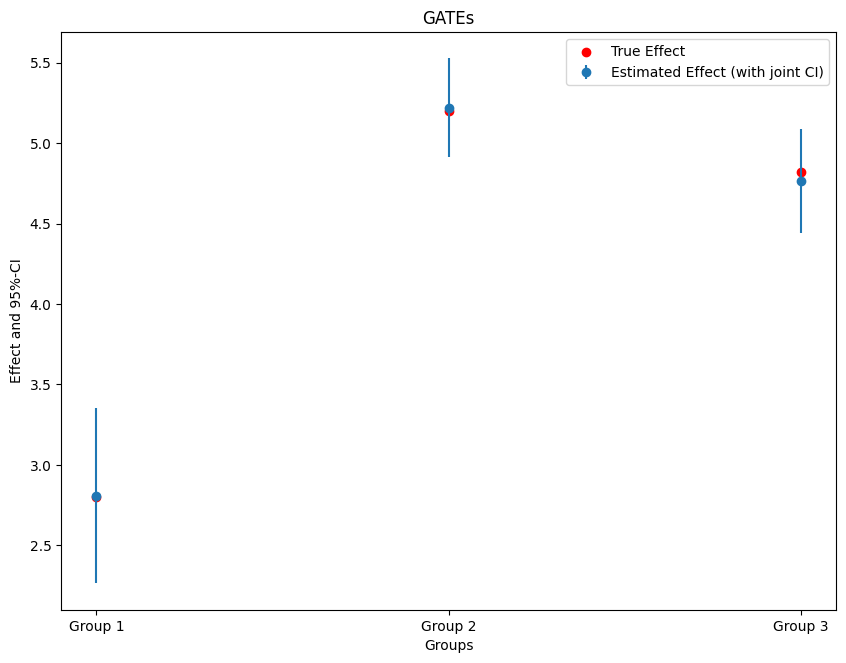

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors, label='Estimated Effect (with joint CI)')

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group 1', 'Group 2', 'Group 3'], y=true_effects, c='red', label='True Effect')

plt.title('GATEs')
plt.xlabel('Groups')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')

It is also possible to supply disjoint groups as a single vector (still as a data frame). Remark the slightly different name.

In [11]:
groups =  pd.DataFrame(columns=['Group'], index=range(data['X_0'].shape[0]), dtype=str)
for i, x_i in enumerate(data['X_0']):
    if x_i <= 0.3:
         groups['Group'][i] = '1'
    elif (x_i > 0.3) & (x_i <= 0.7):
         groups['Group'][i] = '2'
    else:
         groups['Group'][i] = '3'

print(groups.head())

  Group
0     3
1     2
2     2
3     2
4     1


This time lets consider pointwise confidence intervals.

In [12]:
gate = dml_plr.gate(groups=groups)
ci = gate.confint()
print(ci)

            2.5 %    effect    97.5 %
Group_1  2.520096  2.809322  3.098547
Group_2  5.057178  5.219727  5.382277
Group_3  4.593273  4.763769  4.934266


The coefficients of the best linear predictor can be seen via the summary (the values can be accessed through the underlying model ``.blp_model``).

In [13]:
print(gate.summary)

             coef   std err          t          P>|t|    [0.025    0.975]
Group_1  2.809322  0.111415  25.214983   5.837251e-91  2.590420  3.028224
Group_2  5.219727  0.103830  50.271911  5.045313e-197  5.015728  5.423727
Group_3  4.763769  0.099868  47.700840  1.236771e-187  4.567554  4.959984


Remark that the confidence intervals in the summary are slightly smaller, since they are not based on the White's heteroskedasticity robus standard errors.

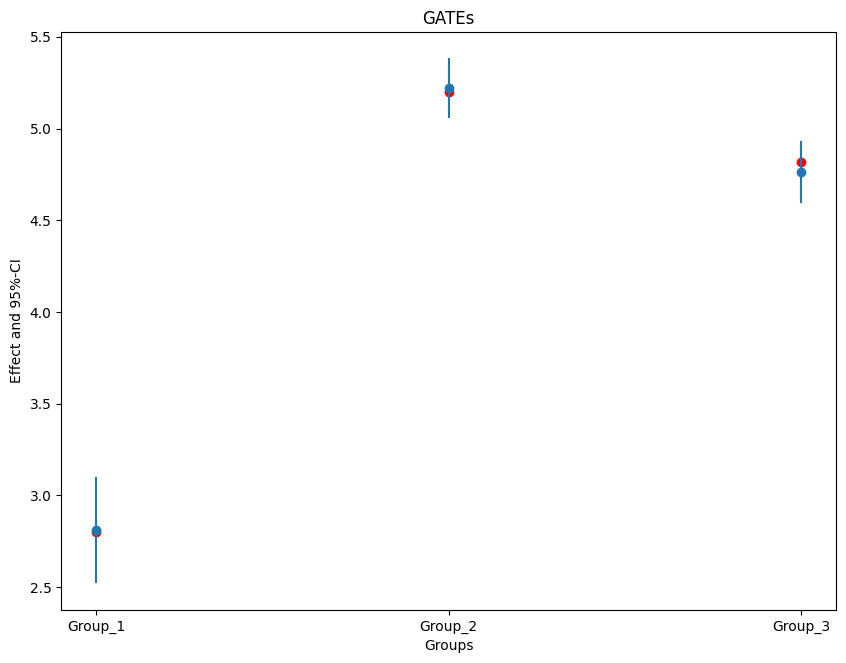

In [14]:
errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group_1', 'Group_2', 'Group_3'], y=true_effects, c='red', label='True Effect')

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors)
plt.title('GATEs')
plt.xlabel('Groups')
_ =  plt.ylabel('Effect and 95%-CI')